# Baseline Models

**Ziel:** Einfache Baseline-Modelle als Benchmark für komplexere Modelle

**Modelle:**
1. Naive Forecast (letzter Wert)
2. Seasonal Naive (Wert vor einer Saison)
3. Moving Average
4. Drift Method
5. Mean Forecast

**Wichtig:** Diese einfachen Modelle dienen als Vergleichswerte. 
Komplexere Modelle sollten diese übertreffen!

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from models.baseline import (
    NaiveForecaster, SeasonalNaiveForecaster, 
    MovingAverageForecaster, DriftForecaster, MeanForecaster
)
from evaluation.metrics import calculate_metrics, print_metrics, compare_models
from visualization.plots import plot_forecast, plot_multiple_forecasts, plot_residuals

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Daten laden

In [2]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

# Lade aufbereitete Daten
train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"\nTrain: {train_df['timestamp'].min()} - {train_df['timestamp'].max()}")
print(f"Test:  {test_df['timestamp'].min()} - {test_df['timestamp'].max()}")

Train: 18262 | Val: 3913 | Test: 3914

Train: 2022-01-09 23:00:00 - 2024-02-09 20:00:00
Test:  2024-07-21 22:00:00 - 2024-12-31 23:00:00


In [3]:
# Arrays für Modelle vorbereiten
y_train = train_df['value'].values
y_val = val_df['value'].values
y_test = test_df['value'].values

timestamps_train = train_df['timestamp']
timestamps_val = val_df['timestamp']
timestamps_test = test_df['timestamp']

print(f"Train shape: {y_train.shape}")
print(f"Test shape: {y_test.shape}")

Train shape: (18262,)
Test shape: (3914,)


## 2. Baseline-Modelle trainieren und evaluieren

### 2.1 Naive Forecast

In [4]:
naive_model = NaiveForecaster()
naive_model.fit(y_train)
naive_pred = naive_model.predict(steps=len(y_test))

naive_metrics = calculate_metrics(y_test, naive_pred, prefix='test_')
print_metrics(naive_metrics, "Naive Forecast")

                       Naive Forecast                       
  test_mae       :    2996.36
  test_rmse      :    3915.66
  test_mape      :      55.40%
  test_smape     :      34.56%
  test_r2        :    -0.9275
  test_mase      :      10.27


### 2.2 Seasonal Naive

In [5]:
# Für stündliche Daten: Saisonalität = 24 (täglich) oder 168 (wöchentlich)
seasonal_naive_model = SeasonalNaiveForecaster(seasonality=24)
seasonal_naive_model.fit(y_train)
seasonal_naive_pred = seasonal_naive_model.predict(steps=len(y_test))

seasonal_naive_metrics = calculate_metrics(y_test, seasonal_naive_pred, prefix='test_')
print_metrics(seasonal_naive_metrics, "Seasonal Naive (24h)")

                    Seasonal Naive (24h)                    
  test_mae       :    2804.93
  test_rmse      :    3562.34
  test_mape      :      48.85%
  test_smape     :      33.25%
  test_r2        :    -0.5954
  test_mase      :       9.61


### 2.3 Moving Average

In [6]:
ma_model = MovingAverageForecaster(window=168)  # 7 Tage
ma_model.fit(y_train)
ma_pred = ma_model.predict(steps=len(y_test))

ma_metrics = calculate_metrics(y_test, ma_pred, prefix='test_')
print_metrics(ma_metrics, "Moving Average (168h)")

                   Moving Average (168h)                    
  test_mae       :    2898.03
  test_rmse      :    3296.32
  test_mape      :      36.24%
  test_smape     :      36.70%
  test_r2        :    -0.3660
  test_mase      :       9.93


### 2.4 Drift Method

In [7]:
drift_model = DriftForecaster()
drift_model.fit(y_train)
drift_pred = drift_model.predict(steps=len(y_test))

drift_metrics = calculate_metrics(y_test, drift_pred, prefix='test_')
print_metrics(drift_metrics, "Drift Method")

                        Drift Method                        
  test_mae       :    2884.57
  test_rmse      :    3739.25
  test_mape      :      52.98%
  test_smape     :      33.70%
  test_r2        :    -0.7578
  test_mase      :       9.89


### 2.5 Mean Forecast

In [8]:
mean_model = MeanForecaster()
mean_model.fit(y_train)
mean_pred = mean_model.predict(steps=len(y_test))

mean_metrics = calculate_metrics(y_test, mean_pred, prefix='test_')
print_metrics(mean_metrics, "Mean Forecast")

                       Mean Forecast                        
  test_mae       :    2536.63
  test_rmse      :    3259.70
  test_mape      :      46.12%
  test_smape     :      30.83%
  test_r2        :    -0.3358
  test_mase      :       8.69


## 3. Modell-Vergleich

In [9]:
# Alle Metriken sammeln
all_results = {
    'Naive': naive_metrics,
    'Seasonal Naive (24h)': seasonal_naive_metrics,
    'Moving Average (168h)': ma_metrics,
    'Drift': drift_metrics,
    'Mean': mean_metrics
}

# Vergleichstabelle erstellen
comparison_df = compare_models(all_results, sort_by='test_rmse')

print("\n" + "=" * 80)
print("BASELINE MODELS - COMPARISON")
print("=" * 80)
display(comparison_df.round(2))

# Bestes Modell identifizieren
best_model = comparison_df['test_rmse'].idxmin()
print(f"\n🏆 Best Baseline Model: {best_model}")
print(f"   RMSE: {comparison_df.loc[best_model, 'test_rmse']:.2f}")


BASELINE MODELS - COMPARISON


,test_mae,test_rmse,test_mape,test_smape,test_r2,test_mase
Mean,2536.63,3259.70,46.12,30.83,-0.34,8.69
Moving Average (168h),2898.03,3296.32,36.24,36.70,-0.37,9.93
Seasonal Naive (24h),2804.93,3562.34,48.85,33.25,-0.60,9.61
Drift,2884.57,3739.25,52.98,33.70,-0.76,9.89
Naive,2996.36,3915.66,55.40,34.56,-0.93,10.27



🏆 Best Baseline Model: Mean
   RMSE: 3259.70


## 4. Visualisierung

### 4.1 Alle Vorhersagen im Vergleich

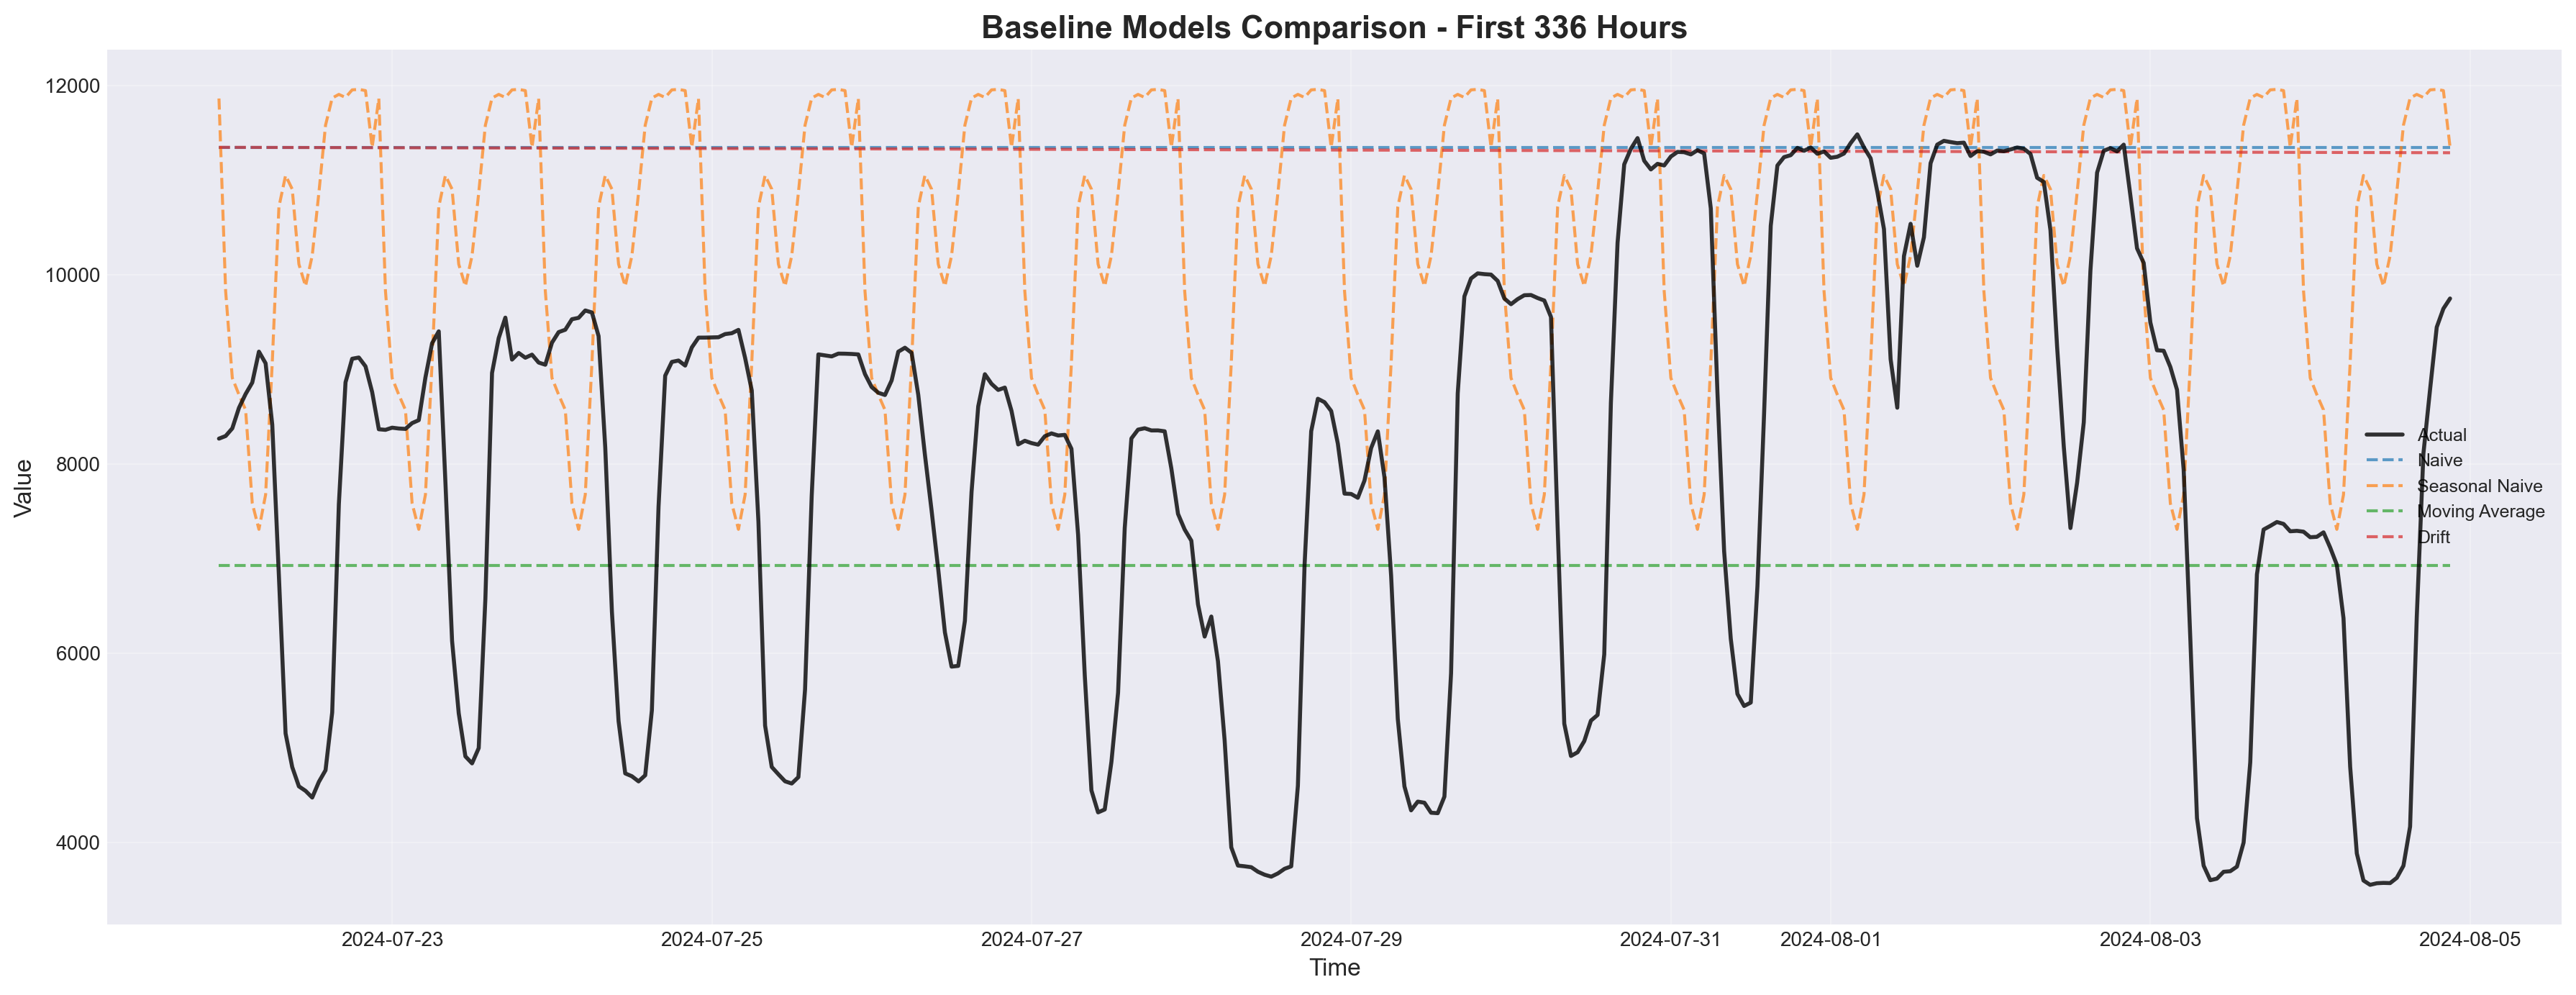

In [10]:
# Zeige nur einen Teil der Test-Daten für bessere Sichtbarkeit
plot_window = 168 * 2  # 2 Wochen

forecasts = {
    'Naive': naive_pred[:plot_window],
    'Seasonal Naive': seasonal_naive_pred[:plot_window],
    'Moving Average': ma_pred[:plot_window],
    'Drift': drift_pred[:plot_window]
}

plot_multiple_forecasts(
    timestamps_test[:plot_window],
    y_test[:plot_window],
    forecasts,
    title=f"Baseline Models Comparison - First {plot_window} Hours",
    figsize=(18, 7)
)

### 4.2 Bestes Modell im Detail

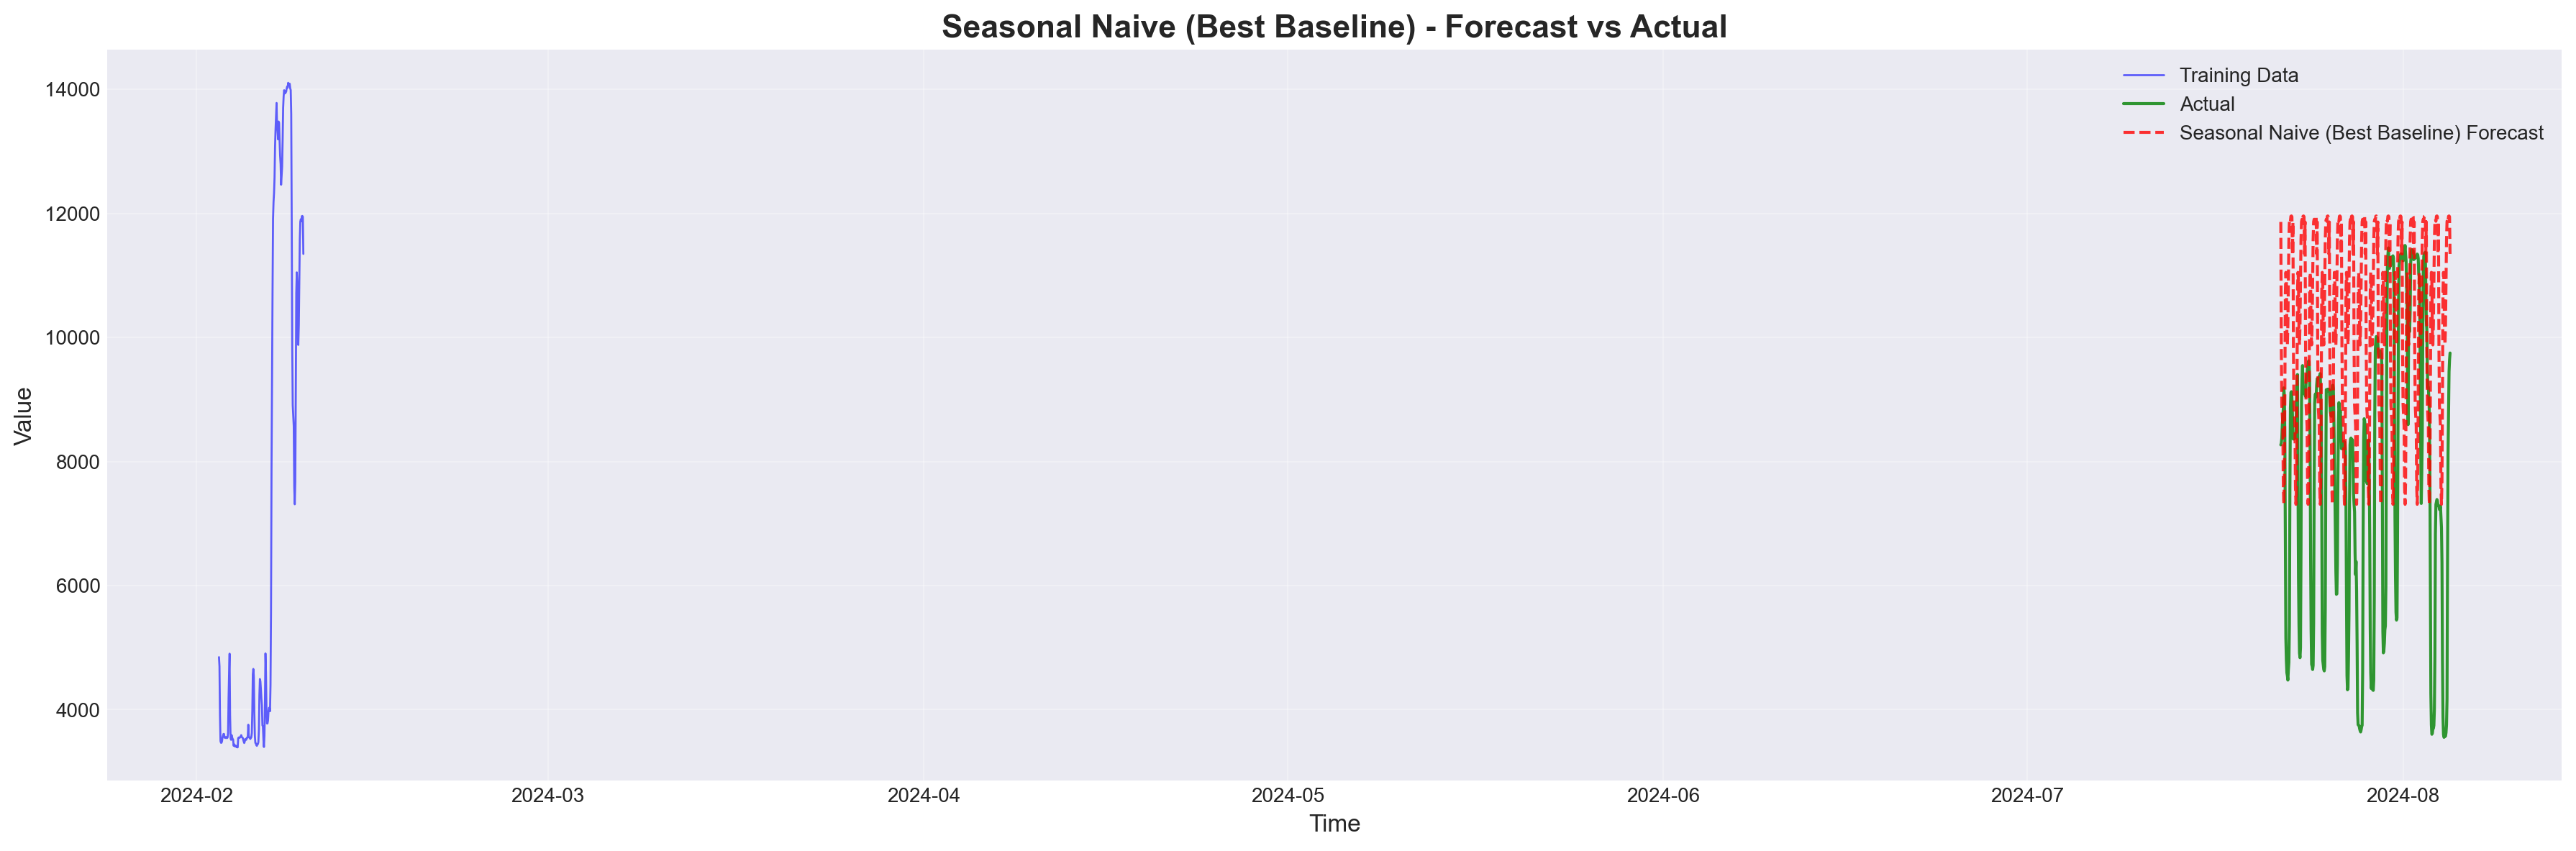

In [11]:
# Seasonal Naive ist oft das beste Baseline-Modell für Energiedaten
plot_forecast(
    timestamps_train[-168:],  # Letzte Woche Training
    y_train[-168:],
    timestamps_test[:plot_window],
    y_test[:plot_window],
    seasonal_naive_pred[:plot_window],
    model_name="Seasonal Naive (Best Baseline)",
    figsize=(18, 6)
)

### 4.3 Residual-Analyse

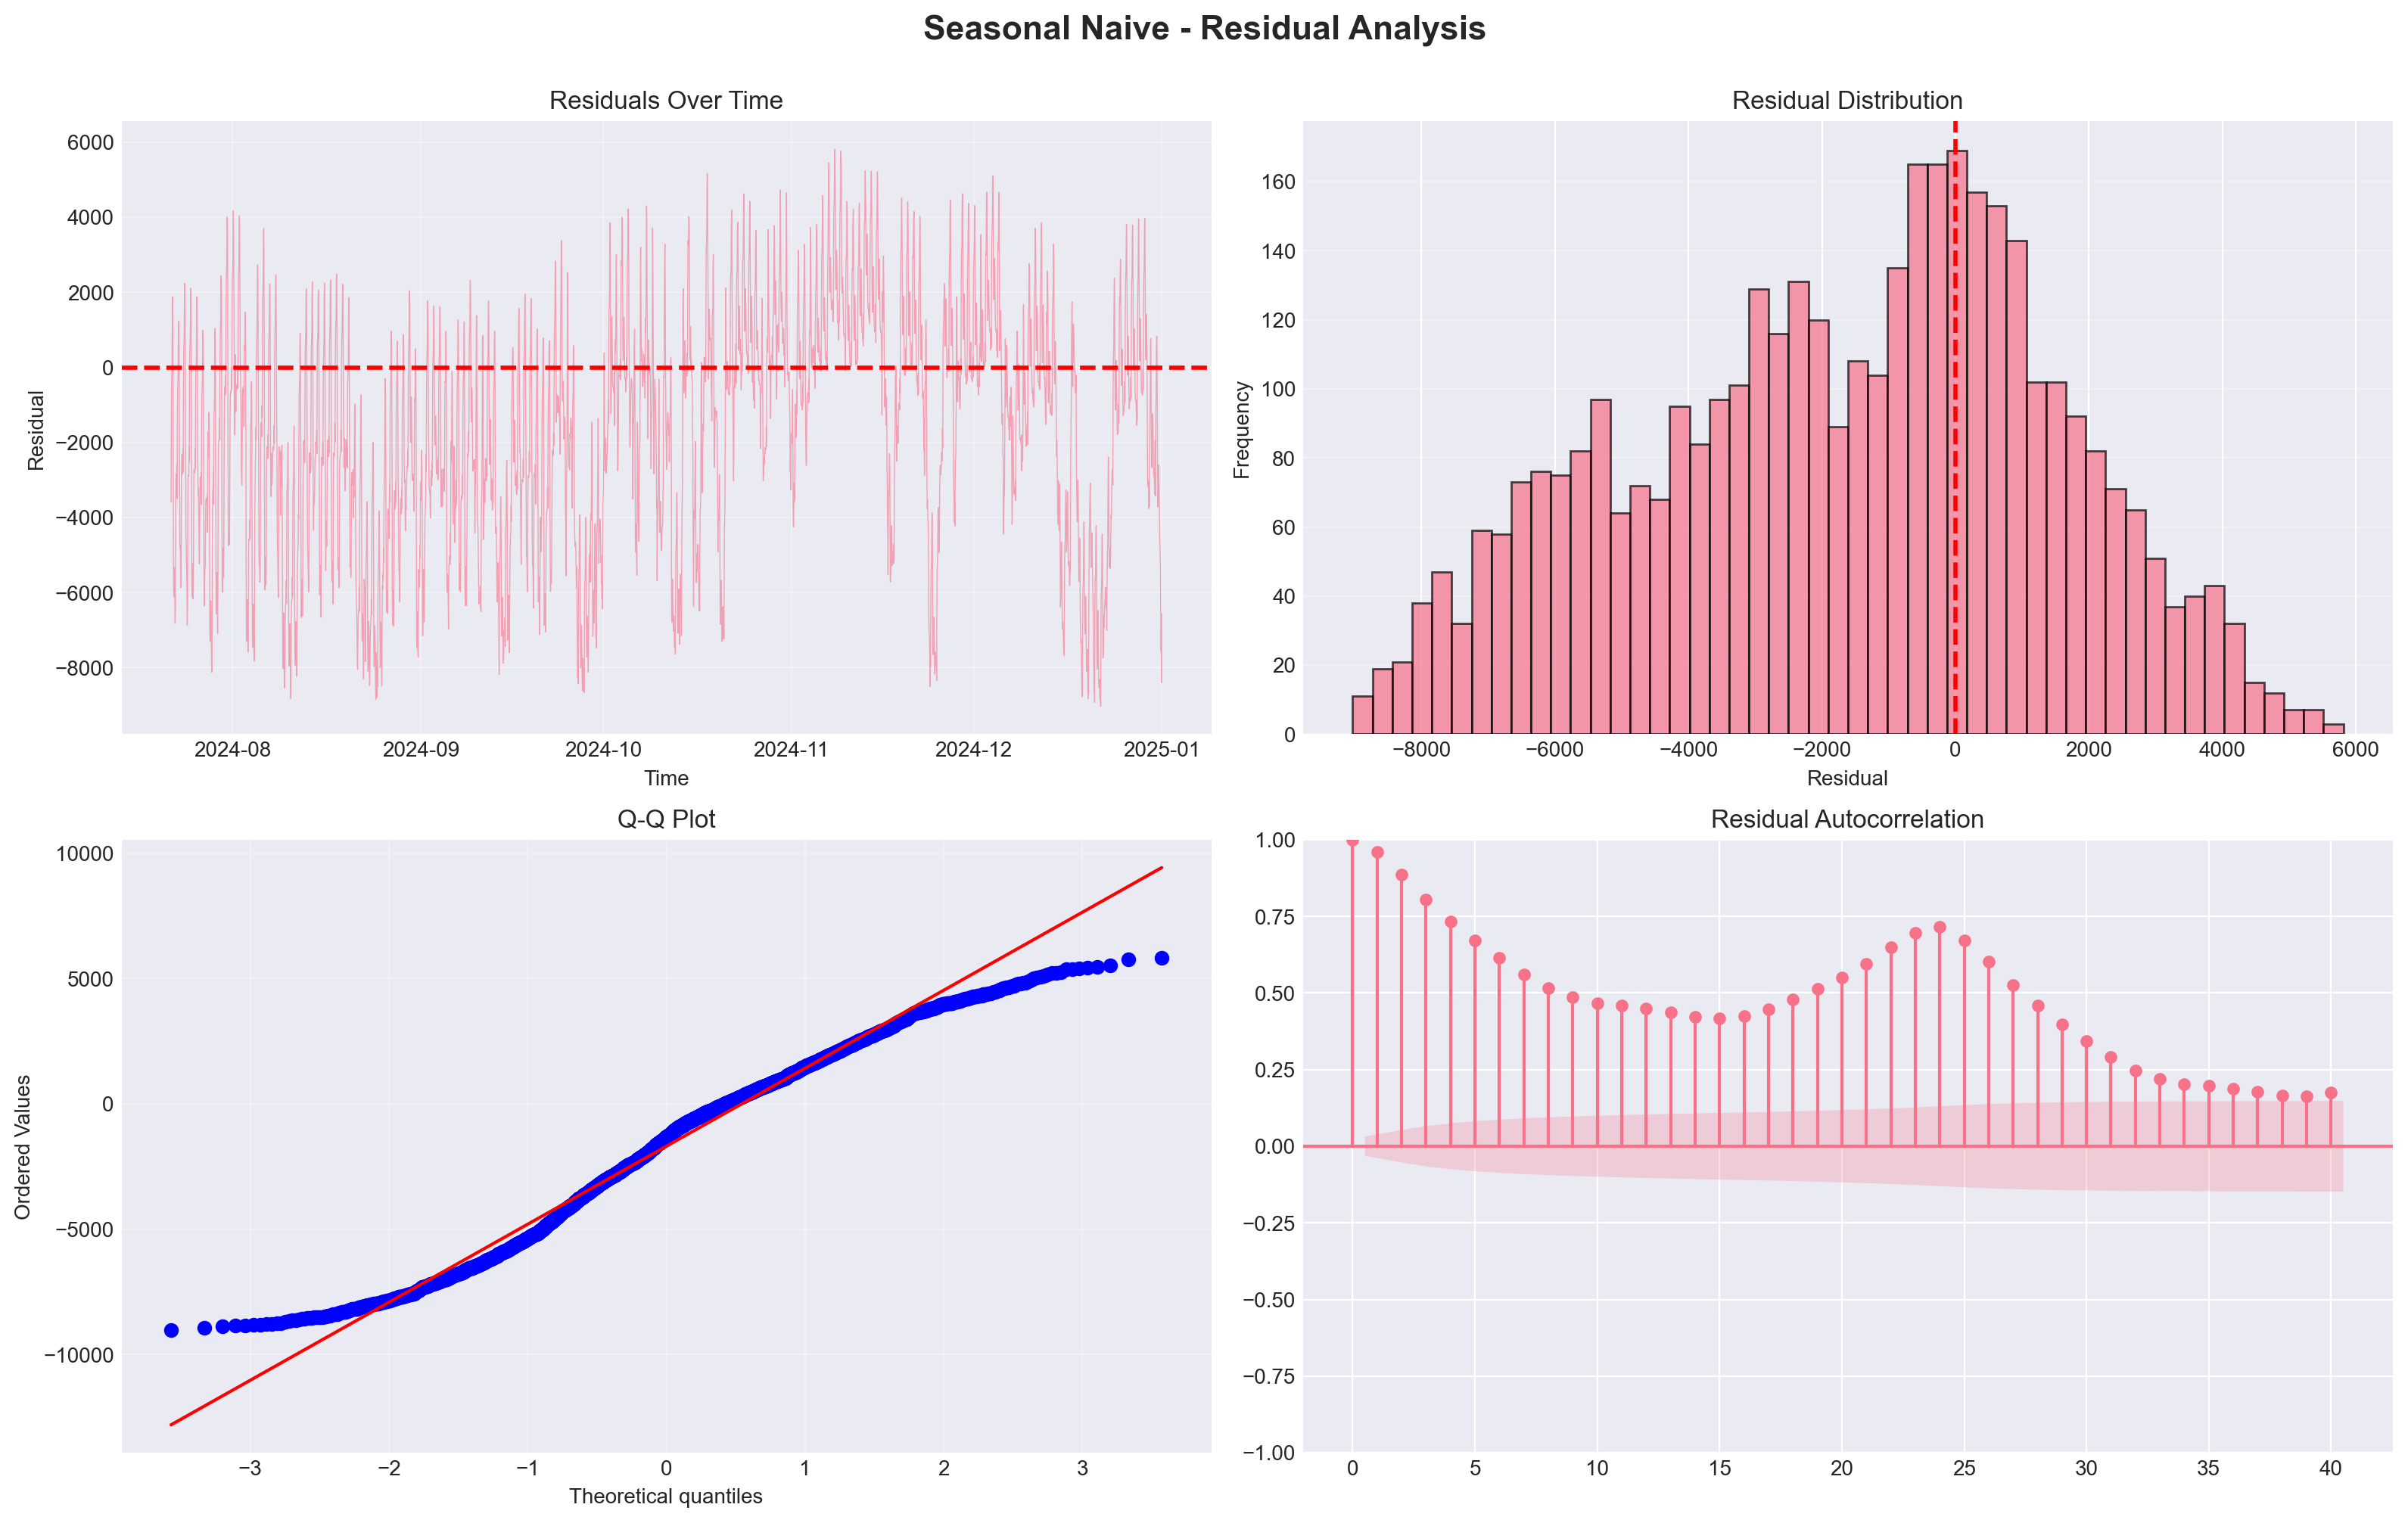

In [12]:
# Residuen des besten Modells
residuals = y_test - seasonal_naive_pred

plot_residuals(
    residuals,
    timestamps=timestamps_test,
    model_name="Seasonal Naive",
    figsize=(16, 10)
)

## 5. Ergebnisse speichern

In [13]:
# Speichere Ergebnisse
results_dir = Path('../results/metrics')
results_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(results_dir / f'{DATA_TYPE}_baseline_results.csv')
print(f"✅ Ergebnisse gespeichert: {results_dir / f'{DATA_TYPE}_baseline_results.csv'}")

✅ Ergebnisse gespeichert: ..\results\metrics\solar_baseline_results.csv


## 6. Zusammenfassung & Erkenntnisse

### Wichtige Erkenntnisse:

1. **Seasonal Naive** performt in der Regel am besten für Energie-Zeitreihen
   - Grund: Starke tägliche Saisonalität (Sonne scheint tagsüber)
   
2. **Naive Forecast** ist sehr einfach, aber oft überraschend gut

3. **Mean/Drift** sind meist schlechter
   - Ignorieren Saisonalität

### Benchmark für komplexere Modelle:

Die folgenden Modelle sollten diese Baselines übertreffen:
- SARIMA (statistische Modelle)
- XGBoost/LightGBM (ML-Modelle)
- LSTM/GRU (Deep Learning)
- TFT/N-BEATS (Advanced DL)

### Nächste Schritte:

Weiter zu **04_statistical_models.ipynb** für SARIMA und ETS!